In [1]:
from THM_main import Version5_THM_prototype
from iapws import IAPWS97
import numpy as np
from THM_main import plotting
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
# Begining of the script used to test the THM prototype class.

In [2]:
# Charger le fichier Excel (remplace 'chemin_du_fichier.xlsx' par le chemin réel)
chemin_fichier = 'BFBT.xlsx'
df = pd.read_excel(chemin_fichier)

# Extraire les 7 premières colonnes
colonnes = df.columns[:7]  # Sélectionne les noms des 7 premières colonnes

# Mettre chaque colonne dans une liste
listes = [df[colonne].tolist() for colonne in colonnes]

powerList = listes[3]
pressureList = listes[1]
temperatureList = listes[4]
flowList = listes[2]
testNumber = listes[0]
densityResult = listes[5]
voidResult = listes[6]

In [3]:
case_name = "PSBT BenchMark Ex1 12223"
#User choice:
solveConduction = False
plot_at_z1 = [0.8]

########## Thermal hydraulics parameters ##########
## Geometric parameters
canalType = "square"
waterRadius = 0.0126 #m
fuelRadius = 0.0027115493728018247
gapRadius = fuelRadius + 0.0000001  # m : expansion gap radius : "void" between fuel and clad - equivalent to inner clad radius
cladRadius =  0.0094996/2 # m : clad external radius
#cladRadius = 0.0133221/2 # m : clad external radius
height = 1.555 # m : height : active core height in BWRX-300 SMR

## Meshing parameters:
If = 8
I1 = 3
Iz1 = 70 # number of control volumes in the axial direction

## Thermalhydraulics correlation
voidFractionCorrel = "EPRIvoidModel"    #choice between 'EPRIvoidModel' and 'GEramp' and 'modBestion' and 'HEM1'
frfaccorel = "Churchill"                #choice between 'Churchill' and 'blasius' 'base'
P2Pcorel = "lockhartMartinelli"                       #choice between 'HEM1' and 'HEM2' and 'MNmodel'
numericalMethod = 'BiCG'            #choice between 'BiCG', 'BiCGStab', 'GaussSiedel' and 'FVM'

############ Nuclear Parameters ###########
## Fission parameters

#qFiss = 1943301220 # W/m3
## Material parameters
kFuel = 4.18 # W/m.K, TECHNICAL REPORTS SERIES No. 59 : Thermal Conductivity of Uranium Dioxide, IAEA, VIENNA, 1966
Hgap = 10000
kClad = 21.5 # W/m.K, Thermal Conductivity of Zircaloy-2 (as used in BWRX-300) according to https://www.matweb.com/search/datasheet.aspx?MatGUID=eb1dad5ce1ad4a1f9e92f86d5b44740d
# k_Zircaloy-4 = 21.6 W/m.K too so check for ATRIUM-10 clad material but should have the same thermal conductivity
########## Algorithm parameters ###########
nIter = 1000
tol = 1e-4

densitySimulated = {}
voidSimulated =  {}
densityMoy = {}
voidMoy = {}
energyList = {}
caseList = {}
frictionList = ['Churchill']#, 'blasius']
P2PList = ['lockhartMartinelli']#, 'MNmodel']#, 'HEM2']

for P2Pcorel in P2PList:
    for frfaccorel in frictionList:
        caseList[P2Pcorel + '_' + frfaccorel] = []
        densitySimulated[P2Pcorel + '_' + frfaccorel] = []
        voidSimulated[P2Pcorel + '_' + frfaccorel] = []
        densityMoy[P2Pcorel + '_' + frfaccorel] = []
        voidMoy[P2Pcorel + '_' + frfaccorel] = []
        energyList[P2Pcorel + '_' + frfaccorel] = []
        for i in range(len(temperatureList)):
            try:
                # Code susceptible de provoquer une erreur*
                ## Fluid and nuclear parameters
                print(i)
                pOutlet = pressureList[i] * 98066.5 # Pa
                tInlet = temperatureList[i] + 273.15 # K
                qFlow = flowList[i] *0.000107098*1000000/3600 # kg/s
                qFiss = 1000 * powerList[i] / (1.555*np.pi*(0.00271154937280182)**2)

                print(f"Temperature: {tInlet} K")
                print(f"Pressure: {pOutlet} Pa")
                print(f"Flow rate: {qFlow} kg/s")
                print(f"Power: {qFiss} W/m3")

                Qfiss1 = []
                for j in range(Iz1):
                    Qfiss1.append(qFiss)

                case0 = Version5_THM_prototype(case_name, canalType,
                                waterRadius, fuelRadius, gapRadius, cladRadius, height, tInlet, pOutlet, qFlow, Qfiss1,
                                kFuel, Hgap, kClad, Iz1, If, I1, plot_at_z1, solveConduction,
                                dt = 0, t_tot = 0, frfaccorel = frfaccorel, P2Pcorel = P2Pcorel, voidFractionCorrel = voidFractionCorrel, numericalMethod = numericalMethod)

                densitySimulated[P2Pcorel + '_' + frfaccorel].append(case0.convection_sol.rho[-1][-1])
                voidSimulated[P2Pcorel + '_' + frfaccorel].append(case0.convection_sol.voidFraction[-1][-1])
                densityMoy[P2Pcorel + '_' + frfaccorel].append(np.mean(case0.convection_sol.rho[-1]))
                print(f'Mean void fraction: {np.mean(case0.convection_sol.voidFraction[-1])}')
                voidMoy[P2Pcorel + '_' + frfaccorel].append(np.mean(case0.convection_sol.voidFraction[-1]))
                energyList[P2Pcorel + '_' + frfaccorel].append(height**2*case0.convection_sol.flowArea*np.mean(case0.convection_sol.q__[-1])/np.mean(case0.convection_sol.U[-1]))
                #caseList[P2Pcorel + '_' + frfaccorel].append(case0)


            except Exception as e:
                print(f'Erreur pour le cas {testNumber[i]}, T: {temperatureList[i]} K, P: {pressureList[i]}  Pa, Q: {powerList[i]} W/m3, F: {flowList[i]} kg/s')
                # Gérer l'erreur, par exemple l'afficher et continuer
                print(f"Une erreur s'est produite à l'itération {i} : {e}")
                # On peut simplement passer à l'itération suivante
                #densitySimulated[P2Pcorel + '_' + frfaccorel].append(800)
                #voidSimulated[P2Pcorel + '_' + frfaccorel].append(0.977)
                #caseList[P2Pcorel + '_' + frfaccorel].append(None)
                continue

0
Temperature: 607.8499999999999 K
Pressure: 16583045.15 Pa
Flow rate: 0.3266489 kg/s
Power: 1392049584.5272255 W/m3
$$$---------- THM: prototype, case treated : PSBT BenchMark Ex1 12223.
$$$---------- THM: prototype, steady state case.
$$---------- Calling DFM class.
Setting up heat convection solution along the axial dimension. zmax = 1.555 m with 70 axial elements.
self.I_z: 70
self.qFlow: 0.3266489
self.pOutlet: 16583045.15
self.Lf: 1.555
self.r_f: 0.0027115493728018247
self.clad_r: 0.0047498
self.r_w: 0.0126
self.Dz: 0.022214285714285714
self.dt: 0
Courant number: 0.0
Numerical Method BiCG
Velocity at the inlet:  5.791254714689528
cote: 0.0126
cladRadius: 0.0047498
Dh: 0.011779139117663314
Hydraulic diameter: [0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139117663314, 0.011779139

c:\Users\cleme\OneDrive\Documents\Poly\BWR\THM_prototype\THM_waterProp.py:563: RuntimeWarning: divide by zero encountered in scalar divide
  return self.U[i] - (self.voidFractionTEMP[i] / ( 1 - self.voidFractionTEMP[i])) * (self.rhogTEMP[i] / self.rhoTEMP[i]) * self.VgjPrimeTEMP[i]
c:\Users\cleme\OneDrive\Documents\Poly\BWR\THM_prototype\THM_waterProp.py:578: RuntimeWarning: invalid value encountered in sqrt
  return 1 + 1/np.sqrt(X) + 20/X


Convergence test, residuals: epsilon: 0.2835476813594977, rho: 0.22121413996145017, xTh: 6.6994844621821334
uInlet:5.796842568908566
VAR_VFM_Class: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.02148745e-02  5.02037944e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.02037944e-02  5.01927143e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.78837847e-05
   8.78837847e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -8.78837847e-05  8.78837847e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
VAR_VFM_Class: [5.79684257e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.

In [4]:

class GFPlotter():
    def __init__(self, caseList, directory_path, case_name):
        self.case_name = f'{case_name}\\'

        self.caseList = caseList
        self.directory_path = directory_path
        self.height = self.caseList[0].convection_sol.height

        self.data_dict_list = []
        self.data_dict = self.read_files_in_directory()
        self.allow_space()

        self.struture_fraction = 1 - (self.alpha_liquid[0] + self.alpha_vapour[0])

        self.calculateFields()
        self.createZ()

    def plotCase(self):
        title = f"f: {self.caseList[0].convection_sol.frfaccorel}, \n Méthode numérique: {self.caseList[0].convection_sol.numericalMethod}, \n Correlation void fraction: {self.caseList[0].convection_sol.voidFractionCorrel}"
        labelTitle = 'DFM'
        fig1, ax1 = plt.subplots()
        for i in range(len(self.caseList)):
            ax1.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.T_water, label=labelTitle)
        ax1.set_xlabel("Axial position in m")
        ax1.set_ylabel("Temperature in K")
        ax1.set_title(f"{title}")
        ax1.grid()
        ax1.legend(loc="best")
        fig1.savefig(rf'result\{self.case_name}\Tcoolant.png', bbox_inches='tight')

        fig2, ax2 = plt.subplots()
        for i in range(len(self.caseList)):
            ax2.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.voidFraction[-1], label=labelTitle)

        ax2.set_xlabel("Axial position in m")
        ax2.set_ylabel("Void fraction")
        ax2.set_title(f"{title}")
        ax2.grid()
        ax2.legend(loc="best")
        fig2.savefig(rf'result\{self.case_name}\epsilon.png', bbox_inches='tight')

        fig3, ax3 = plt.subplots()
        print(f"rho_mix GenFoam: {self.rho_mixture}")
        for i in range(len(self.caseList)):
            ax3.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.rho[-1], label=labelTitle)

        ax3.set_xlabel("Axial position in m")
        ax3.set_ylabel("Density in kg/m^3")
        ax3.set_title(f"{title}")
        ax3.grid()
        ax3.legend(loc="best")
        fig3.savefig(rf'result\{self.case_name}\Rho.png', bbox_inches='tight')

        fig7, ax7 = plt.subplots()
        for i in range(len(self.caseList)):
            ax7.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.rhoL[-1], label=labelTitle)
        ax7.set_xlabel("Axial position in m")
        ax7.set_ylabel("Liquid density in kg/m^3")
        ax7.set_title(f"{title}")
        ax7.grid()
        ax7.legend(loc="best")
        fig7.savefig(rf'result\{self.case_name}\RhoL.png', bbox_inches='tight')

        fig8, ax8 = plt.subplots()
        for i in range(len(self.caseList)):
            ax8.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.rhoG[-1], label=labelTitle)
        ax8.set_xlabel("Axial position in m")
        ax8.set_ylabel("Vapour density in kg/m^3")
        ax8.set_title(f"{title}")
        ax8.grid()
        ax8.legend(loc="best")
        fig8.savefig(rf'result\{self.case_name}\RhoG.png', bbox_inches='tight')

        fig4, ax4 = plt.subplots() 
        for i in range(len(self.caseList)):
            labelTitle = f"DFM {self.caseList[i].convection_sol.frfaccorel}"
            ax4.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.P[-1], label=labelTitle)
        ax4.step(self.zList, self.p_rgh, label="GenFoam P_rgh")
        ax4.set_xlabel("Axial position in m")
        ax4.set_ylabel("Pressure in Pa")
        ax4.grid()
        ax4.set_title(f"{title}")
        ax4.legend(loc="best")
        fig4.savefig(rf'result\{self.case_name}\P.png', bbox_inches='tight')

        fig5, ax5 = plt.subplots()
        for i in range(len(self.caseList)):
            ax5.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.Ul, label=labelTitle)
        ax5.set_xlabel("Axial position in m")
        ax5.set_ylabel("Liquid Velocity in m/s")
        ax5.set_title(f"{title}")
        ax5.grid()
        ax5.legend(loc="best")
        fig5.savefig(rf'result\{self.case_name}\Ul.png', bbox_inches='tight')

        fig6, ax6 = plt.subplots()
        for i in range(len(self.caseList)):
            ax6.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.Ug, label=labelTitle)
        ax6.set_xlabel("Axial position in m")
        ax6.set_ylabel("Vapour Velocity in m/s")
        ax6.set_title(f"{title}")
        ax6.grid()
        ax6.legend(loc="best")
        fig6.savefig(rf'result\{self.case_name}\Ug.png', bbox_inches='tight')

        fig9, ax9 = plt.subplots()
        for i in range(len(self.caseList)):
            ax9.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.U[-1], label=labelTitle)
        ax9.set_xlabel("Axial position in m")
        ax9.set_ylabel("Mixture Velocity in m/s")
        ax9.set_title(f"{title}")
        ax9.grid()
        ax9.legend(loc="best")
        fig9.savefig(rf'result\{self.case_name}\U.png', bbox_inches='tight')

        fig10, ax10 = plt.subplots()
        for i in range(len(self.caseList)):
            ax10.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.Rel, label=labelTitle)
        ax10.set_xlabel("Axial position in m")
        ax10.set_ylabel("Reynolds number")
        ax10.set_title(f"{title}")
        ax10.grid()
        ax10.legend(loc="best")
        fig10.savefig(rf'result\{self.case_name}\Re.png', bbox_inches='tight')

        fig11, ax11 = plt.subplots()
        ax11.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.xTh[-1], label=labelTitle)
        ax11.set_xlabel("Axial position in m")
        ax11.set_ylabel("xTh")
        ax11.set_title(f"{title}")
        ax11.grid()
        ax11.legend(loc="best")
        fig11.savefig(rf'result\{self.case_name}\xTh.png', bbox_inches='tight')

        
        fig12, ax12 = plt.subplots()
        for i in range(len(self.caseList)):
            rhoUA_liquid = [self.caseList[i].convection_sol.Ul[j] * self.caseList[i].convection_sol.rhoL[-1][j]*self.caseList[i].convection_sol.areaMatrix[j] for j in range(len(self.caseList[i].convection_sol.Ul))]
            ax12.step(self.caseList[i].convection_sol.z_mesh, rhoUA_liquid, label=labelTitle + " rhoUA_liquid")
        #ax12.step(self.zList, self.alphaRhoMagU_liquid, label="GenFoam")
        ax12.set_xlabel("Axial position in m")
        ax12.set_ylabel("rhoUA_liquid")
        ax12.set_title(f"{title}")
        ax12.grid()
        fig12.savefig(rf'result\{self.case_name}\rhoUA_liquid.png', bbox_inches='tight')

        fig13, ax13 = plt.subplots()
        for i in range(len(self.caseList)):
            rhoUA_vapour = [self.caseList[i].convection_sol.Ug[j] * self.caseList[i].convection_sol.rhoG[-1][j]*self.caseList[i].convection_sol.areaMatrix[j] for j in range(len(self.caseList[i].convection_sol.Ug))]
            ax13.step(self.caseList[i].convection_sol.z_mesh, rhoUA_vapour, label=labelTitle + " rhoUA_vapour")
        #ax13.step(self.zList, self.alphaRhoMagU_vapour, label="GenFoam")
        ax13.set_xlabel("Axial position in m")
        ax13.set_ylabel("rhoUA_vapour")
        ax13.set_title(f"{title}")
        ax13.grid()
        fig13.savefig(rf'result\{self.case_name}\rhoUA_vapour.png', bbox_inches='tight')

        fig14, ax14 = plt.subplots()
        for i in range(len(self.caseList)):
            self.rhoUA = [self.caseList[i].convection_sol.U[-1][j] * self.caseList[i].convection_sol.rho[-1][j]*self.caseList[i].convection_sol.areaMatrix[j] for j in range(len(self.caseList[i].convection_sol.Ug))]
            ax14.step(self.caseList[i].convection_sol.z_mesh, self.rhoUA, label=labelTitle + " rhoUA")
        #ax14.step(self.zList, self.alphaRhoMagU_liquid, label="GenFoam")
        ax14.set_xlabel("Axial position in m")
        ax14.set_ylabel("rhoUA")
        ax14.set_title(f"{title}")
        ax14.grid()
        fig14.savefig(rf'result\{self.case_name}\rhoUA.png', bbox_inches='tight')
        

        plt.show()

    def createZ(self):
        self.zList = np.linspace(0, self.height, len(self.alpha_liquid))

    def read_files_in_directory(self):
        data_dict = {}
        print(f"Reading files in directory: {self.directory_path}")
        # Parcourt tous les fichiers du dossier
        for filename in os.listdir(self.directory_path):
            file_path = os.path.join(self.directory_path, filename)
            print(f"Reading file: {file_path}")
            # Vérifie que c'est bien un fichier
            if os.path.isfile(file_path):

                with open(file_path, 'r') as file:
                    content = file.read()
                    
                    # Trouve la première parenthèse ouvrante et fermante
                    start = content.find('(')
                    end = content.find(')', start)
                    #end = start + 74
                    if start != -1 and end != -1:
                        # Extrait les données entre les parenthèses
                        data_str = content[start+1:end].strip()
                        # Divise les lignes en liste de chaînes
                        data_lines = data_str.splitlines()
                        if len(data_lines) != 1:
                            float_list = [float(item) for item in data_lines]
                            data_dict[filename] = float_list

                    if len(data_lines) == 1:
                        # Trouve la première parenthèse ouvrante et fermante
                        start = content.find('(')
                        end = content.find(';', start)
                        #end = start
                        if start != -1 and end != -1:
                            # Extrait les données entre les parenthèses
                            data_str = content[start+1:end].strip()
                            # Divise les lignes en liste de chaînes
                            data_lines = data_str.splitlines()
                            data_lines.pop()
                            x, y, z = np.zeros(len(data_lines)), np.zeros(len(data_lines)), np.zeros(len(data_lines))
                            for i in range(len(data_lines)):
                                a = values = data_lines[i].strip("()").split()
                                x[i] = float(a[0])
                                y[i] = float(a[1])
                                z[i] = float(a[2])
                            data_dict[fr'{filename}_x'] = x
                            data_dict[fr'{filename}_y'] = y
                            data_dict[fr'{filename}_z'] = z
        
        return data_dict
    
    def allow_space(self):
        self.alpha_liquid = np.array(self.data_dict['alpha.liquid'])
        self.alpha_vapour = np.array(self.data_dict['alpha.vapour'])
        #self.alpha_powerModel = np.array(self.data_dict['alpha.powerModel'])
        self.alphaPhi_liquid = np.array(self.data_dict['alphaPhi.liquid']+ [self.data_dict['alphaPhi.liquid'][-1]])
        self.alphaPhi_vapour = np.array(self.data_dict['alphaPhi.vapour']+ [self.data_dict['alphaPhi.vapour'][-1]])
        self.alphaRhoMagU_liquid = np.array(self.data_dict['alphaRhoMagU.liquid'])#+ [self.data_dict['alphaRhoMagU.liquid'][-1]])
        self.alphaRhoMagU_vapour = np.array(self.data_dict['alphaRhoMagU.vapour'])#+ [self.data_dict['alphaRhoMagU.vapour'][-1]])
        self.alphaRhoPhi_liquid = np.array(self.data_dict['alphaRhoPhi.liquid']+ [self.data_dict['alphaRhoPhi.liquid'][-1]])
        self.alphaRhoPhi_vapour = np.array(self.data_dict['alphaRhoPhi.vapour']+ [self.data_dict['alphaRhoPhi.vapour'][-1]])
        self.areaDensity_interface = np.array(self.data_dict['areaDensity.interface'])
        self.dgdt_liquid = np.array(self.data_dict['dgdt.liquid'])
        self.dgdt_vapour = np.array(self.data_dict['dgdt.vapour'])
        self.dmdt_vapour = np.array(self.data_dict['dmdt.liquid.vapour'])
        self.heatFlux_structure = np.array(self.data_dict['heatFlux.structure'])
        self.htc_liquid_interface = np.array(self.data_dict['htc.liquid.interface'])
        self.htc_liquid_structure = np.array(self.data_dict['htc.liquid.structure'])
        self.p = np.array(self.data_dict['p'])
        self.p_rgh = np.array(self.data_dict['p_rgh'])
        self.Re_liquid_structure = np.array(self.data_dict['Re.liquid.structure'])
        #self.Re_vapour_structure = np.array(self.data_dict['Re.vapour.structure'])
        self.Re_liquid_vapour = np.array(self.data_dict['Re.liquid.vapour'])
        self.T_fixedPower = np.array(self.data_dict['T.fixedPower'])
        self.T_liquid = np.array(self.data_dict['T.liquid'])
        self.T_vapour = np.array(self.data_dict['T.vapour'])
        self.U_liquid_x = np.array(self.data_dict['U.liquid_x'])
        self.U_liquid_y = np.array(self.data_dict['U.liquid_y'])
        self.U_liquid_z = np.array(self.data_dict['U.liquid_z'])
        self.U_vapour_x = np.array(self.data_dict['U.vapour_x'])
        self.U_vapour_y = np.array(self.data_dict['U.vapour_y'])
        self.U_vapour_z = np.array(self.data_dict['U.vapour_z'])

    def calculateFields(self):
        self.alpha_vapour = self.alpha_vapour/(1-self.struture_fraction)
        self.alpha_liquid = self.alpha_liquid/(1-self.struture_fraction)
        self.U_liquid = np.sqrt(self.U_liquid_x**2 + self.U_liquid_y**2 + self.U_liquid_z**2)
        self.U_vapour = np.sqrt(self.U_vapour_x**2 + self.U_vapour_y**2 + self.U_vapour_z**2)
        self.U_mixture = (1-self.alpha_vapour) * self.U_liquid + self.alpha_vapour * self.U_vapour

        self.rho_liquid  = self.alphaRhoPhi_liquid/(self.alphaPhi_liquid)
        self.rho_vapour = self.alphaRhoPhi_vapour/(self.alphaPhi_vapour)
        for i in range(len(self.rho_vapour)):
            if np.isnan(self.rho_vapour[i]):
                self.rho_vapour[i] = 0
            if np.isnan(self.rho_liquid[i]):
                self.rho_liquid[i] = 0
        print(f"rho_liquid GeN-Foam: {self.rho_liquid}")
        print(f"rho_vapour GeN-Foam: {self.rho_vapour}")
        self.rho_mixture = self.rho_liquid + self.rho_vapour

        self.T_mixture = (1-self.alpha_vapour) * self.T_liquid + self.alpha_vapour * self.T_vapour

    def plotComparison(self):
        file_path = rf'C:\Users\cleme\OneDrive\Documents\Poly\BWR\driftFluxModel\thermalHydraulicsPoro\result\{self.case_name}'
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        if len(self.caseList) == 1:
            labelTitle = 'DFM'
        labelTitle = 'DFM'
        title = f"f: {self.caseList[0].convection_sol.frfaccorel}, \n Méthode numérique: {self.caseList[0].convection_sol.numericalMethod}, \n Correlation void fraction: {self.caseList[0].convection_sol.voidFractionCorrel}"
        fig1, ax1 = plt.subplots()
        for i in range(len(self.caseList)):
            ax1.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.T_water, label=labelTitle)
        ax1.step(self.zList, self.T_liquid, label="GenFoam T.liquid")
        ax1.step(self.zList, self.T_vapour, label="GenFoam T.vapour")
        ax1.step(self.zList, self.T_mixture, label="GenFoam T.mixture")
        ax1.set_xlabel("Axial position in m")
        ax1.set_ylabel("Temperature in K")
        ax1.set_title(f"{title}")
        ax1.grid()
        ax1.legend(loc="best")
        fig1.savefig(rf'result\{self.case_name}\Tcoolant.png', bbox_inches='tight')

        fig2, ax2 = plt.subplots()
        for i in range(len(self.caseList)):
            ax2.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.voidFraction[-1], label=labelTitle)
        ax2.step(self.zList, self.alpha_vapour, label="GenFoam")
        ax2.set_xlabel("Axial position in m")
        ax2.set_ylabel("Void fraction")
        ax2.set_title(f"{title}")
        ax2.grid()
        ax2.legend(loc="best")
        fig2.savefig(rf'result\{self.case_name}\epsilon.png', bbox_inches='tight')

        fig3, ax3 = plt.subplots()
        print(f"rho_mix GeN-Foam: {self.rho_mixture}")
        for i in range(len(self.caseList)):
            ax3.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.rho[-1], label=labelTitle)
        ax3.plot(self.zList, self.rho_mixture, label="GenFoam")
        ax3.set_xlabel("Axial position in m")
        ax3.set_ylabel("Density in kg/m^3")
        ax3.set_title(f"{title}")
        ax3.grid()
        ax3.legend(loc="best")
        fig3.savefig(rf'result\{self.case_name}\Rho.png', bbox_inches='tight')

        fig7, ax7 = plt.subplots()
        for i in range(len(self.caseList)):
            ax7.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.rhoL[-1], label=labelTitle)
        ax7.plot(self.zList, self.rho_liquid, label="GenFoam")
        ax7.set_xlabel("Axial position in m")
        ax7.set_ylabel("Liquid density in kg/m^3")
        ax7.set_title(f"{title}")
        ax7.grid()
        ax7.legend(loc="best")
        fig7.savefig(rf'result\{self.case_name}\RhoL.png', bbox_inches='tight')

        fig8, ax8 = plt.subplots()
        for i in range(len(self.caseList)):
            ax8.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.rhoG[-1], label=labelTitle)
        ax8.plot(self.zList, self.rho_vapour, label="GenFoam")
        ax8.set_xlabel("Axial position in m")
        ax8.set_ylabel("Vapour density in kg/m^3")
        ax8.set_title(f"{title}")
        ax8.grid()
        ax8.legend(loc="best")
        fig8.savefig(rf'result\{self.case_name}\RhoG.png', bbox_inches='tight')

        fig4, ax4 = plt.subplots() 
        for i in range(len(self.caseList)):
            labelTitle = f"DFM {self.caseList[i].convection_sol.frfaccorel} {self.caseList[i].convection_sol.P2Pcorel}"
            ax4.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.P[-1], label=labelTitle)
        ax4.step(self.zList, self.p, label="GenFoam")
        ax4.step(self.zList, self.p_rgh, label="GenFoam P_rgh")
        ax4.set_xlabel("Axial position in m")
        ax4.set_ylabel("Pressure in Pa")
        ax4.grid()
        ax4.set_title(f"{title}")
        ax4.legend(loc="best")
        fig4.savefig(rf'result\{self.case_name}\P.png', bbox_inches='tight')

        fig5, ax5 = plt.subplots()
        for i in range(len(self.caseList)):
            ax5.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.Ul, label=labelTitle)
        ax5.step(self.zList, self.U_liquid, label="GenFoam")
        ax5.set_xlabel("Axial position in m")
        ax5.set_ylabel("Liquid Velocity in m/s")
        ax5.set_title(f"{title}")
        ax5.grid()
        ax5.legend(loc="best")
        fig5.savefig(rf'result\{self.case_name}\Ul.png', bbox_inches='tight')

        fig6, ax6 = plt.subplots()
        for i in range(len(self.caseList)):
            ax6.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.Ug, label=labelTitle)
        ax6.step(self.zList, self.U_vapour, label="GenFoam")
        ax6.set_xlabel("Axial position in m")
        ax6.set_ylabel("Vapour Velocity in m/s")
        ax6.set_title(f"{title}")
        ax6.grid()
        ax6.legend(loc="best")
        fig6.savefig(rf'result\{self.case_name}\Ug.png', bbox_inches='tight')

        fig9, ax9 = plt.subplots()
        for i in range(len(self.caseList)):
            ax9.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.U[-1], label=labelTitle)
        ax9.step(self.zList, self.U_mixture, label="GenFoam")
        ax9.set_xlabel("Axial position in m")
        ax9.set_ylabel("Mixture Velocity in m/s")
        ax9.set_title(f"{title}")
        ax9.grid()
        ax9.legend(loc="best")
        fig9.savefig(rf'result\{self.case_name}\U.png', bbox_inches='tight')

        fig10, ax10 = plt.subplots()
        for i in range(len(self.caseList)):
            ax10.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.Rel, label=labelTitle)
        ax10.step(self.zList, self.Re_liquid_structure, label="GenFoam")
        ax10.set_xlabel("Axial position in m")
        ax10.set_ylabel("Reynolds number")
        ax10.set_title(f"{title}")
        ax10.grid()
        ax10.legend(loc="best")
        fig10.savefig(rf'result\{self.case_name}\Re.png', bbox_inches='tight')

        fig11, ax11 = plt.subplots()
        ax11.step(self.caseList[i].convection_sol.z_mesh, self.caseList[i].convection_sol.xTh[-1], label=labelTitle)
        ax11.set_xlabel("Axial position in m")
        ax11.set_ylabel("xTh")
        ax11.set_title(f"{title}")
        ax11.grid()
        ax11.legend(loc="best")
        fig11.savefig(rf'result\{self.case_name}\xTh.png', bbox_inches='tight')

        
        fig12, ax12 = plt.subplots()
        for i in range(len(self.caseList)):
            rhoUA_liquid = [self.caseList[i].convection_sol.Ul[j] * self.caseList[i].convection_sol.rhoL[-1][j]*self.caseList[i].convection_sol.areaMatrix[j] for j in range(len(self.caseList[i].convection_sol.Ul))]
            ax12.step(self.caseList[i].convection_sol.z_mesh, rhoUA_liquid, label=labelTitle + " rhoUA_liquid")
        #ax12.step(self.zList, self.alphaRhoMagU_liquid, label="GenFoam")
        ax12.set_xlabel("Axial position in m")
        ax12.set_ylabel("rhoUA_liquid")
        ax12.set_title(f"{title}")
        ax12.grid()
        fig12.savefig(rf'result\{self.case_name}\rhoUA_liquid.png', bbox_inches='tight')

        fig13, ax13 = plt.subplots()
        for i in range(len(self.caseList)):
            rhoUA_vapour = [self.caseList[i].convection_sol.Ug[j] * self.caseList[i].convection_sol.rhoG[-1][j]*self.caseList[i].convection_sol.areaMatrix[j] for j in range(len(self.caseList[i].convection_sol.Ug))]
            ax13.step(self.caseList[i].convection_sol.z_mesh, rhoUA_vapour, label=labelTitle + " rhoUA_vapour")
        #ax13.step(self.zList, self.alphaRhoMagU_vapour, label="GenFoam")
        ax13.set_xlabel("Axial position in m")
        ax13.set_ylabel("rhoUA_vapour")
        ax13.set_title(f"{title}")
        ax13.grid()
        fig13.savefig(rf'result\{self.case_name}\rhoUA_vapour.png', bbox_inches='tight')

        fig14, ax14 = plt.subplots()
        for i in range(len(self.caseList)):
            self.rhoUA = [self.caseList[i].convection_sol.U[-1][j] * self.caseList[i].convection_sol.rho[-1][j]*self.caseList[i].convection_sol.areaMatrix[j] for j in range(len(self.caseList[i].convection_sol.Ug))]
            ax14.step(self.caseList[i].convection_sol.z_mesh, self.rhoUA, label=labelTitle + " rhoUA")
        #ax14.step(self.zList, self.alphaRhoMagU_liquid, label="GenFoam")
        ax14.set_xlabel("Axial position in m")
        ax14.set_ylabel("rhoUA")
        ax14.set_title(f"{title}")
        ax14.grid()
        fig14.savefig(rf'result\{self.case_name}\rhoUA.png', bbox_inches='tight')
        

        plt.show()

    def computeErrors(self):
        self.error_T_abs = []
        self.error_T_rel = []
        self.error_p_abs = []
        self.error_p_rel = []
        self.error_rho_abs = []
        self.error_rho_rel = []
        self.error_U_abs = []
        self.error_U_rel = []
        self.error_Re_abs = []
        self.error_Re_rel = []
        self.error_eps_abs = []
        self.error_eps_rel = []

        for i in range(len(self.caseList)):
            self.error_T_abs.append((self.T_mixture - self.caseList[i].convection_sol.T_water))
            self.error_T_rel.append(100*self.error_T_abs[-1]/(self.T_mixture))
            self.error_p_abs.append((self.p - self.caseList[i].convection_sol.P[-1]))
            self.error_p_rel.append(100*self.error_p_abs[-1]/(self.p))
            self.error_rho_abs.append(self.rho_mixture - self.caseList[i].convection_sol.rho[-1])
            self.error_rho_rel.append(100*self.error_rho_abs[-1]/(self.rho_mixture))
            self.error_U_abs.append((self.U_mixture - self.caseList[i].convection_sol.U[-1]))
            self.error_U_rel.append(100*self.error_U_abs[-1]/(self.U_mixture))
            self.error_Re_abs.append((self.Re_liquid_structure - self.caseList[i].convection_sol.Rel))
            self.error_Re_rel.append(100*self.error_Re_abs[-1]/(self.Re_liquid_structure))
            self.error_eps_abs.append((self.alpha_vapour - self.caseList[i].convection_sol.voidFraction[-1]))
            self.error_eps_rel.append(self.error_eps_abs[-1]/(self.alpha_vapour))

            

    def plotErrorsPressure(self):
        fig, ax = plt.subplots()
        for i in range(len(self.caseList)):
            print(self.error_p_abs)
            ax.step(self.caseList[i].convection_sol.z_mesh, self.error_p_abs[i], label=f" {self.caseList[i].convection_sol.frfaccorel} , {self.caseList[i].convection_sol.P2Pcorel}")
        ax.set_xlabel("Axial position in m")
        ax.set_ylabel("Absolute error in Pa")
        ax.set_title("Absolute error in pressure")
        ax.grid()
        ax.legend(loc="best")
        fig.savefig(rf'result\{self.case_name}\error_p_abs.png', bbox_inches='tight')

        fig1, ax1 = plt.subplots()
        for i in range(len(self.caseList)):
            ax1.step(self.caseList[i].convection_sol.z_mesh, self.error_p_rel[i], label=f" {self.caseList[i].convection_sol.frfaccorel} , {self.caseList[i].convection_sol.P2Pcorel}")
        ax1.set_xlabel("Axial position in m")
        ax1.set_ylabel("Relative error in %")
        ax1.set_title("Relative error in pressure")
        ax1.grid()
        ax1.legend(loc="best")
        fig1.savefig(rf'result\{self.case_name}\error_p_rel.png', bbox_inches='tight')

        plt.show()

        for i in range(len(self.caseList)):
            print(f"Mean relative error in pressure: {np.mean(self.error_p_rel[i])}, max relative error in pressure {np.max(self.error_p_rel[i])} for {self.caseList[i].convection_sol.frfaccorel}, {self.caseList[i].convection_sol.P2Pcorel}")

In [5]:
# Convertir le dictionnaire en DataFrame
#voidSimulated['Experimental'] = voidResult
#df = pd.DataFrame(voidSimulated)

# Écrire dans un fichier Excel
#df.to_excel('voidSimulated.xlsx', index=False)  # index=False pour ne pas écrire l'index dans Excel

#print("Le fichier Excel a été créé avec succès.")

def plotPoints(voidResult, voidSimulated, densityResult, densitySimulated, legend):
    mid = np.linspace(0, 1, 10)
    midyPos = [i+0.1 for i in mid]
    midyNeg = [i-0.1 for i in mid]
    print(f'voidResult: {voidResult}')
    print(f'voidSimulated: {voidSimulated}')
    fig1, ax1 = plt.subplots()
    ax1.scatter(voidResult, voidSimulated, label =f"{legend}")
    ax1.plot(mid, mid, color='black')
    ax1.plot(mid, midyPos, color='black', linestyle='--')
    ax1.plot(mid, midyNeg, color='black', linestyle='--')
    plt.xlabel("Experimental void fraction")
    plt.ylabel("Simulated void fraction")
    ax1.grid()
    ax1.legend(loc="best")

    """ for i in range(len(voidResults)):
        if voidResults[i] == 0.977:
            print(f"Error for case {testNumber[i]}")
        elif voidSimulated[i] >= voidResults[i] + 0.11:
            print(f"Error superior to 10% for case {testNumber[i]}. Condition: {pressureList[i]} Pa, {temperatureList[i]} K, {powerList[i]} W/m3, {flowList[i]} kg/s")
        elif voidSimulated[i] <= voidResults[i] - 0.11:
            print(f"Error inferior to 10% for case {testNumber[i]}. Condition: {pressureList[i]} Pa, {temperatureList[i]} K, {powerList[i]} W/m3, {flowList[i]} kg/s") """

    mid = np.linspace(0, 800, 10)
    midyPos = [i+80 for i in mid]
    midyNeg = [i-80 for i in mid]
    midmidyPos = [i+160 for i in mid]
    midmidyNeg = [i-160 for i in mid]
    fig2, ax2 = plt.subplots()
    ax2.scatter(densityResult, densitySimulated, label =f"{legend}")
    ax2.plot(mid, mid, color='black')
    ax2.plot(mid, midyPos, color='black', linestyle='--')
    ax2.plot(mid, midyNeg, color='black', linestyle='--')
    ax2.plot(mid, midmidyPos, color='red', linestyle='--')
    ax2.plot(mid, midmidyNeg, color='red', linestyle='--')
    plt.xlabel("Density experimental")
    plt.ylabel("Density simulated")
    ax2.grid()
    ax2.legend(loc="best")

    """ for i in range(len(densityResult)):
        if densityResult[i] == 800:
            print(f"Error for case {testNumber[i]}")
        elif densityResult[i] >= densitySimulated[i] + 80:
            print(f"Error for case {testNumber[i]}")
        elif densityResult[i] <= densitySimulated[i] - 80:
            print(f"Error for case {testNumber[i]}") """


def computeErrors(voidSimulated, void, densitySimulated, density):
    error_void = []
    error_density = []

    for i in range(len(voidResult)):
        error_void.append(voidResult[i] - void[i])
        error_density.append((densityResult[i] - density[i])/densityResult[i])

    return error_void, error_density

def plotErrors(voidSimulated, voidResult, densitySimulated, densityResult):
    for legend in voidSimulated.keys():
        void = voidSimulated[legend]
        density = densitySimulated[legend]
        error_void, error_density = computeErrors(void, voidResult, density, densityResult)
        fig1, ax1 = plt.subplots()
        print(f'Error void fraction for {legend}: {error_void}')
        print(f'Error density for {legend}: {error_density}')


def plotEnergy(voidResult, void, densityResult, density, legend, energy):
    errors = [void[i] - voidResult[i] for i in range(len(void))]
    print(f"Errors: {errors}")
    print(f"Energy: {energy}")
    fig3, ax3 = plt.subplots()
    ax3.scatter(energy, errors, label=legend)
    plt.xlabel("Mean energy in Ws/m4 (q/u)")
    plt.ylabel("Error in void fraction")
    plt.grid()
    plt.title("Error in void fraction (sim - exp) as a function of energy")
    # Ajout de la ligne horizontale rouge en pointillé à y=0
    ax3.axhline(y=0, color='red', linestyle='--')
    
    # Récupération des limites de l'axe des x
    xlims = ax3.get_xlim()
    
    # Ajout du texte "over estimated" au-dessus à droite de la ligne
    ax3.text(xlims[1], 0, "over estimated", color='red', ha='right', va='bottom')
    
    # Ajout du texte "under estimated" en dessous à gauche de la ligne
    ax3.text(xlims[1], 0, "under estimated", color='red', ha='right', va='top')
    
    plt.legend()



Energy:  {'lockhartMartinelli_Churchill': [13132.228576975132, 12300.88371035651, 17464.485299647535, 16255.767535463985, 27390.712407802184, 26812.322510065558, 21406.445995333284, 18634.352493233848, 18423.61400340524, 17772.32780363067, 17279.78655514548, 16564.27649933245, 15630.495054270514, 14586.059942736027, 41396.59868499952, 38168.57080861611, 34279.256503169825, 18091.82270466273, 15998.048485497548, 13379.892653345358, 21857.49083313995, 14351.28785425619, 54945.07329211792, 42667.240050052234, 47227.038306735456, 44214.896844763665, 41888.32359204398, 37358.31609400399, 32424.70710761185, 25805.570191975028, 34598.10496076353, 25740.271765204314, 37927.60201398159, 30826.92081016085, 24129.99535325689, 53861.14601148123, 38272.76822218105, 39572.96139444361, 34706.21487674868, 21605.58515167751, 35694.872793761446, 22423.715863069323]}
voidResult: [0.142, 0.332, 0.063, 0.218, 0.038, 0.079, 0.048, 0.311, 0.013, 0.06, 0.08, 0.25, 0.308, 0.44, 0.053, 0.182, 0.508, 0.053, 0.35

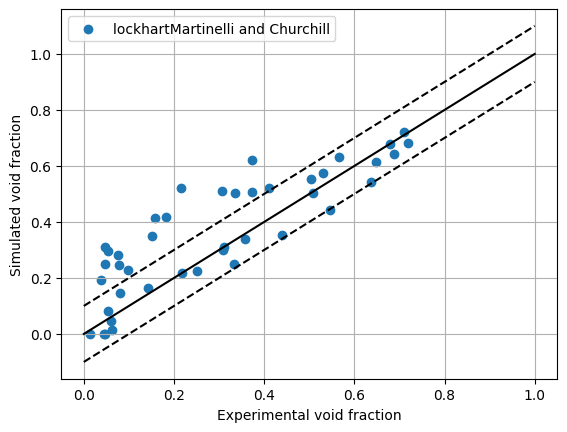

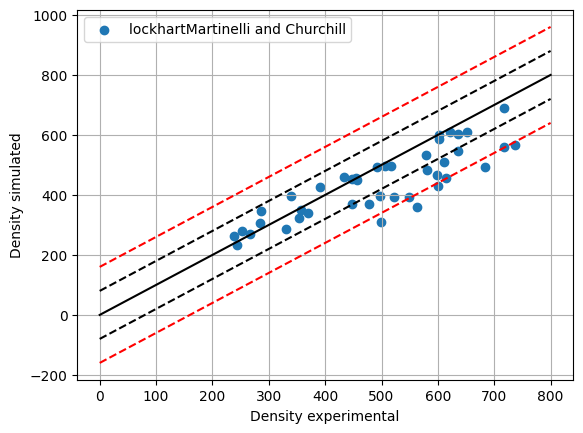

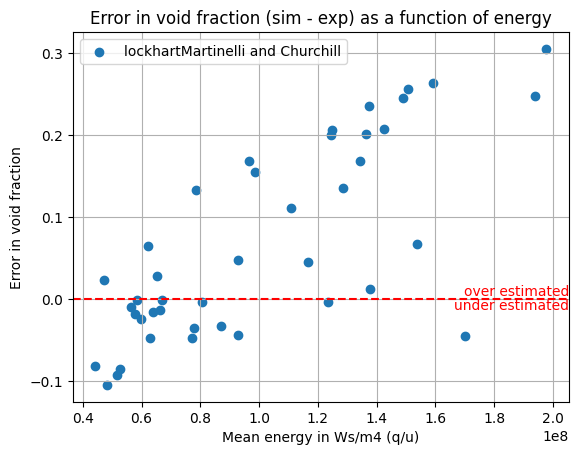

In [6]:
print('Energy: ', energyList)
for P2Pcorel in P2PList:
    for frfaccorel in frictionList:
        void = voidSimulated[P2Pcorel + '_' + frfaccorel]
        density = densitySimulated[P2Pcorel + '_' + frfaccorel]
        E = [energyList[P2Pcorel + '_' + frfaccorel][i] * 3600 for i in range(len(void))]
        legend = f"{P2Pcorel} and {frfaccorel}"
        plotPoints(voidResult, void, densityResult, density, legend)
        plotEnergy(voidResult, void, densityResult, density, legend, E)
plt.show()